In [116]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import dotenv_values
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from config import get_connection
from data.db import execute_sql
from data.notifcation_preparation import prepare_dataset, flat_notifications_from_sql
from data.preprocessing import DataPreprocessor

In [117]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

In [110]:
LOCAL_DATA_PATH = os.path.join('..', 'data', 'sample_notifications_data.parquet')
LOCAL_DATA_MODE = True

def load_dataset(data_path=None, conf_path="../.env") -> pd.DataFrame:
    if not data_path or (data_path and not os.path.exists(data_path)):
        print("Reading from db")
        conf = dotenv_values(conf_path)
        conn = get_connection(conf)
        notifications = execute_sql(conn, "select * from notifications order by id")
        raw_flat_data = prepare_dataset(flat_notifications_from_sql(notifications))
        data_preprocessor = DataPreprocessor(raw_flat_data, is_train= True)
        return data_preprocessor.provide_ready_df()
    else:
        print("Reading from local file")
        return pd.read_parquet(data_path)

In [111]:
df = load_dataset(LOCAL_DATA_PATH)

Reading from local file


In [112]:
df

,_01_h_bars_vol_to_28d_avg_h_vol,_02_h_bars_vol_to_28d_avg_h_vol,_03_h_bars_vol_to_28d_avg_h_vol,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_close,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-10_days_low,btc_stats_statsMap_-10_days_open,btc_stats_statsMap_-12_hours_avg1HourVolume,...,history_statsMap_-6_hours_low,history_statsMap_-6_hours_open,history_statsMap_-7_days_avg1HourVolume,history_statsMap_-7_days_changeRate,history_statsMap_-7_days_high,history_statsMap_-7_days_low,history_statsMap_-7_days_open,label_down_return,label_up_return,price
0,5.192318,7.658774,0.980625,823.18,-10.0,42520.7,47600.1,42108.0,47299.7,135.07,...,0.361500,0.36190,79818.16,-33.0,0.585800,0.356200,0.553300,-17.584416,1.662338,0.385000
1,0.688743,0.150720,0.165391,823.18,-10.0,42520.7,47600.1,42108.0,47299.7,135.07,...,0.275900,0.28040,60903.32,-7.0,0.355800,0.252800,0.297400,-18.024862,1.312155,0.289600
4,2.150151,1.136304,1.130103,823.18,-10.0,42520.7,47600.1,42108.0,47299.7,135.07,...,0.050550,0.05146,284673.24,-22.0,0.068400,0.050030,0.065310,-14.995279,4.494806,0.052950
5,2.150151,1.136304,1.130103,823.18,-10.0,42520.7,47600.1,42108.0,47299.7,135.07,...,0.050550,0.05146,284673.24,-22.0,0.068400,0.050030,0.065310,-15.075472,4.396226,0.053000
6,0.805183,0.933732,0.815942,823.18,-10.0,42520.7,47600.1,42108.0,47299.7,135.07,...,0.000724,0.00075,5508550.15,-18.0,0.000976,0.000702,0.000891,-11.512718,2.141901,0.000747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88977,1.008475,0.819213,0.832194,571.35,5.0,20276.8,22500.0,18902.5,19227.6,863.97,...,0.053970,0.05408,130473.05,1.0,0.078500,0.051800,0.054060,-11.803279,4.262295,0.061000
88978,1.008475,0.819213,0.832194,571.35,5.0,20276.8,22500.0,18902.5,19227.6,863.97,...,0.053970,0.05408,130473.05,1.0,0.078500,0.051800,0.054060,-12.648157,0.340964,0.061590
88979,2.869205,5.121461,6.225751,571.35,5.0,20276.8,22500.0,18902.5,19227.6,863.97,...,0.012550,0.01285,32100.99,-11.0,0.015970,0.012510,0.014100,-20.538966,1.310998,0.013730
88980,1.008475,0.819213,0.832194,571.35,5.0,20276.8,22500.0,18902.5,19227.6,863.97,...,0.053970,0.05408,130473.05,1.0,0.078500,0.051800,0.054060,-12.163265,0.897959,0.061250


In [113]:
#xg = load_dataset()
#xg.to_parquet(LOCAL_DATA_PATH)

In [114]:
# from data.scalers import min_max_scaler, standard_scaler
# df_norm = min_max_scaler(df)
# df_std= standard_scaler(df)

In [118]:
from verta import Client
client = Client("http://localhost:3333")

proj = client.set_project("Trading Singals")
expt = client.set_experiment("Extra Trees")

connection successfully established
got existing Project: Trading Singals
got existing Experiment: Extra Trees


In [119]:
label_cols = ['label_up_return', 'label_down_return']
x = df.drop(label_cols, axis=1)
y_up = df['label_up_return']
y_down = df['label_down_return']

In [120]:
x.shape

(52388, 673)

In [121]:
from model_factory import ModelFactory
_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()

2022-07-19 11:49:51,333 - root - INFO - Creating label column up_20_return with threshold of 20
2022-07-19 11:49:51,340 - root - INFO - label_20_up
0              43945
1               8443
dtype: int64


label_20_up
0              43945
1               8443
dtype: int64

In [122]:
def train(clf, x_train, y_train):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    return score

In [123]:
y_up_class.shape

(52388, 1)

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x, y_up_class, test_size=0.2)

In [15]:
algos = {
    "Nearest_Neighbors": KNeighborsClassifier(3),
     #"Linear_SVM": SVC(kernel="linear", C=0.025),
     #"Polynomial_SVM": SVC(kernel="poly", degree=3, C=0.025),
     #"RBF_SVM": SVC(kernel="rbf", C=1, gamma=2),
     #"Gaussian_Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
     "Gradient_Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
     "Decision_Tree": DecisionTreeClassifier(max_depth=5),
     "Extra_Trees": ExtraTreesClassifier(n_estimators=10, min_samples_split=2), 
     "Random_Forest": RandomForestClassifier(max_depth=5, n_estimators=100), 
     "Neural_Net": MLPClassifier(alpha=1, max_iter=1000), 
     "AdaBoost": AdaBoostClassifier(n_estimators=100),
     "Naive_Bayes": GaussianNB(),
     "QDA": QuadraticDiscriminantAnalysis(),
     "SGD": SGDClassifier(loss="hinge", penalty="l2")
}


In [13]:
scores = []
models = []
result = {}

In [16]:
def train_gen(algos_dict):
    for name, clf in algos_dict.items():
        print(f"Training {name} model")
        score = train(clf, x_train, y_train)
        yield name, score, clf
check_list = ["Nearest_Neighbors", 
              "Gradient_Boosting", 
              "Extra_Trees",
              "Random_Forest",
              "Neural_Net",
              "AdaBoost",
              "Naive_Bayes"
              ]
for name, score, model in train_gen({k: v for k, v in algos.items() if k in check_list}):
    result[name] = model
    scores.append(score)
    models.append(model)

Training Nearest_Neighbors model
Training Gradient_Boosting model
Training Extra_Trees model
Training Random_Forest model
Training Neural_Net model
Training AdaBoost model
Training Naive_Bayes model


C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_18660\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [17]:
df = pd.DataFrame()
df['name'] = check_list
df['score'] = scores

df

,name,score
0,Nearest_Neighbors,0.875740
1,Gradient_Boosting,0.884902
2,Extra_Trees,0.936247
3,Random_Forest,0.841000
4,Neural_Net,0.751098
5,AdaBoost,0.838710
6,Naive_Bayes,0.164344


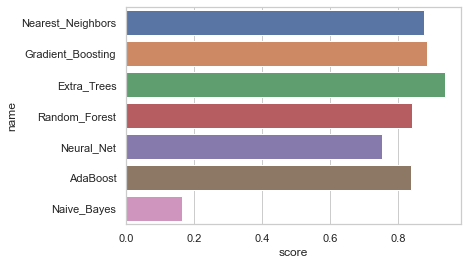

In [18]:
sns.set(style="whitegrid")

ax = sns.barplot(y="name", x="score", data=df)

In [125]:
def train_eval_model(x_train, x_test, y_train, y_test, model, name, thresh=20):
    run = client.set_experiment_run(name)
    print(f"Training model {name}")
    score = train(model, x_train, y_train)
    print(f"Score {score}")
    run.log_metric('score', score, overwrite=True)
    print(f"Evaluating model {name}")
    run.log_artifact('model', a1, overwrite=True)
    # Make predictions for the test UP set
    y_up_predictions = model.predict(x_test)
    # View accuracy score

    acc = accuracy_score(y_test, y_up_predictions)
    run.log_metric('accuracy', acc, overwrite=True)
    print(acc)
    
    print(f"precision {precision_score(y_test, y_up_predictions)}")
    recall = recall_score(y_test, y_up_predictions)
    print(f"recall { recall}")
    run.log_metric('recall', recall, overwrite=True)

    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    run.log_metric('auc', auc, overwrite=True)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_test, y_up_predictions)
    print(matrix)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    from sklearn.metrics import plot_precision_recall_curve
    plot_precision_recall_curve(model, x_test, y_test)
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = [f'Higher than {thresh}%', f'Lower Than {thresh}%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_up_predictions))
    

In [126]:
models_dict = {}
def name_model(prefix, pars_dict):
    return f"{prefix} {'['.join(f'{k}_{v}' for k, v in pars_dict.items())}"

In [ ]:
pars = {"n_estimators": 100,
"min_samples_split": 2,
"max_depth": 50,
"max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")

feat_importances = pd.Series(a1.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

got existing ExperimentRun: QEW n_estimators_100[min_samples_split_2[max_depth_40[max_features_0.75
Training model QEW n_estimators_100[min_samples_split_2[max_depth_40[max_features_0.75
Score 0.9437869822485208
Evaluating model QEW n_estimators_100[min_samples_split_2[max_depth_40[max_features_0.75
upload complete (model)
0.9437869822485208
precision 0.9219001610305958
recall 0.6994502138057422
[[8744   97]
 [ 492 1145]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8841
           1       0.92      0.70      0.80      1637

    accuracy                           0.94     10478
   macro avg       0.93      0.84      0.88     10478
weighted avg       0.94      0.94      0.94     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


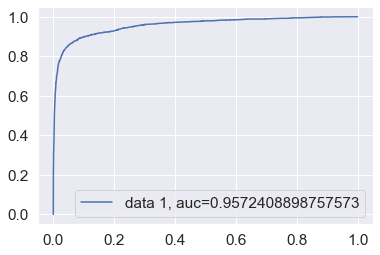

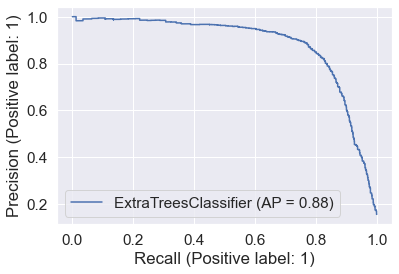

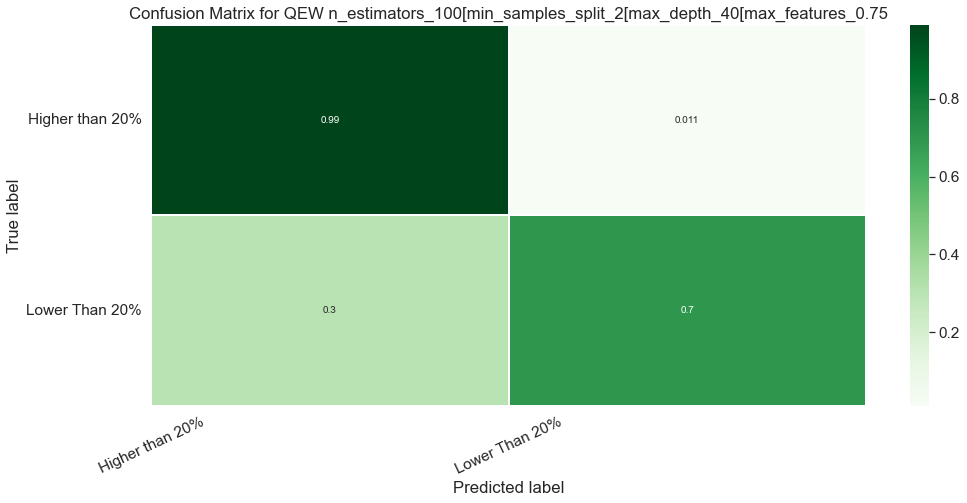

In [129]:
pars = {"n_estimators": 100,
"min_samples_split": 2,
"max_depth": 40,
"max_features": 0.75}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")

created new ExperimentRun: QEW n_estimators_100[min_samples_split_2[max_depth_50[max_features_0.75
Training model QEW n_estimators_100[min_samples_split_2[max_depth_50[max_features_0.75
Score 0.9438824203092193
Evaluating model QEW n_estimators_100[min_samples_split_2[max_depth_50[max_features_0.75
upload complete (model)
0.9438824203092193
precision 0.9240097008892482
recall 0.6982284667073916
[[8747   94]
 [ 494 1143]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8841
           1       0.92      0.70      0.80      1637

    accuracy                           0.94     10478
   macro avg       0.94      0.84      0.88     10478
weighted avg       0.94      0.94      0.94     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


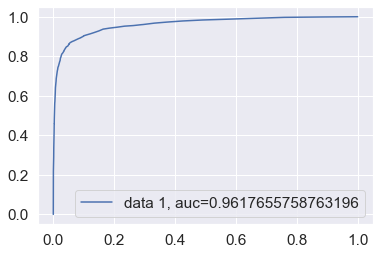

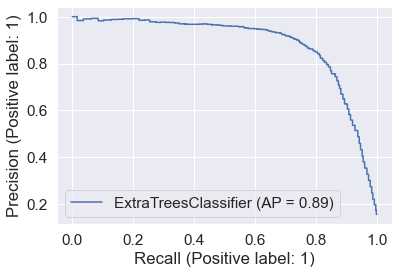

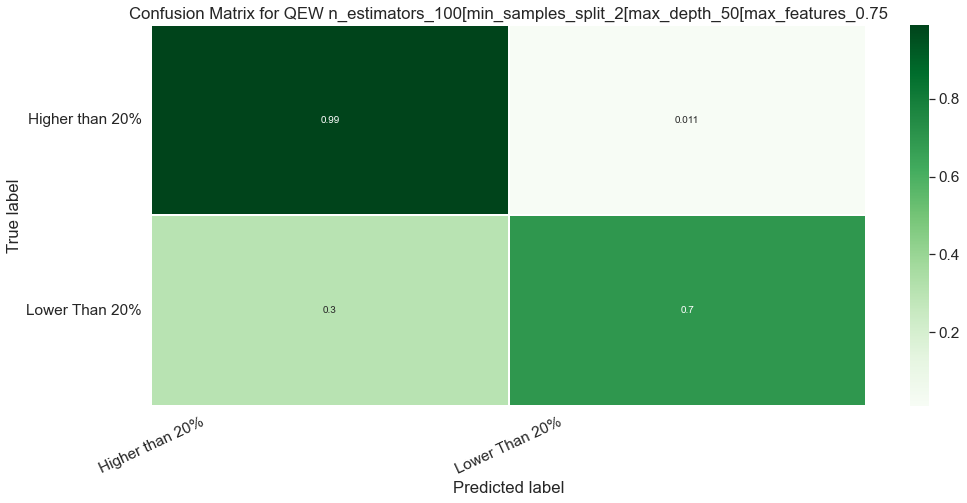

In [132]:
pars = {"n_estimators": 100,
"min_samples_split": 2,
"max_depth": 50,
"max_features": 0.75}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")

created new ExperimentRun: QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_0.75
Training model QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_0.75
Score 0.9294712731437297
Evaluating model QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_0.75
upload complete (model)
0.9294712731437297
precision 0.9376218323586745
recall 0.5876603543066585
[[8777   64]
 [ 675  962]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8841
           1       0.94      0.59      0.72      1637

    accuracy                           0.93     10478
   macro avg       0.93      0.79      0.84     10478
weighted avg       0.93      0.93      0.92     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


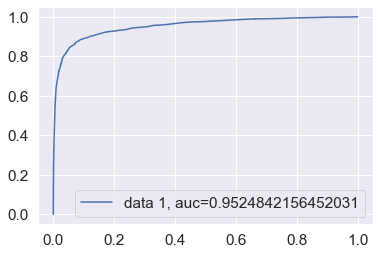

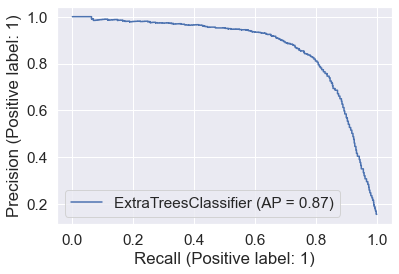

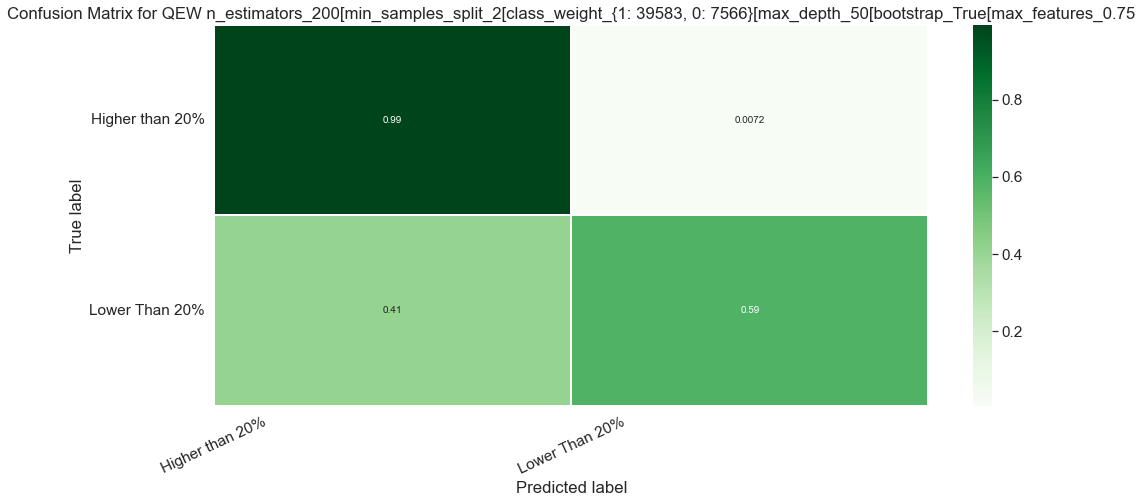

In [138]:
pars = {"n_estimators": 200,
"min_samples_split": 2,
"class_weight": {1: 39583, 0: 7566},
"max_depth": 50,
"bootstrap": True,
"max_features": 0.75}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")

got existing ExperimentRun: QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_sqrt
Training model QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_sqrt
Score 0.925271998472991
Evaluating model QEW n_estimators_200[min_samples_split_2[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True[max_features_sqrt
upload complete (model)
0.925271998472991
precision 0.9278557114228457
recall 0.5656689065363469
[[8769   72]
 [ 711  926]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8841
           1       0.93      0.57      0.70      1637

    accuracy                           0.93     10478
   macro avg       0.93      0.78      0.83     10478
weighted avg       0.93      0.93      0.92     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


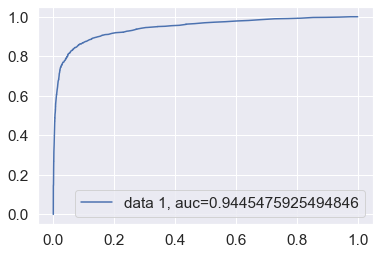

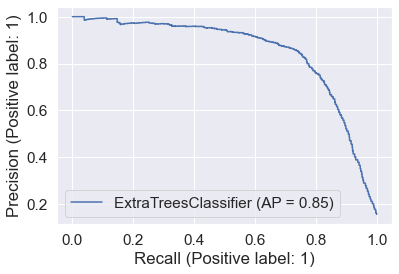

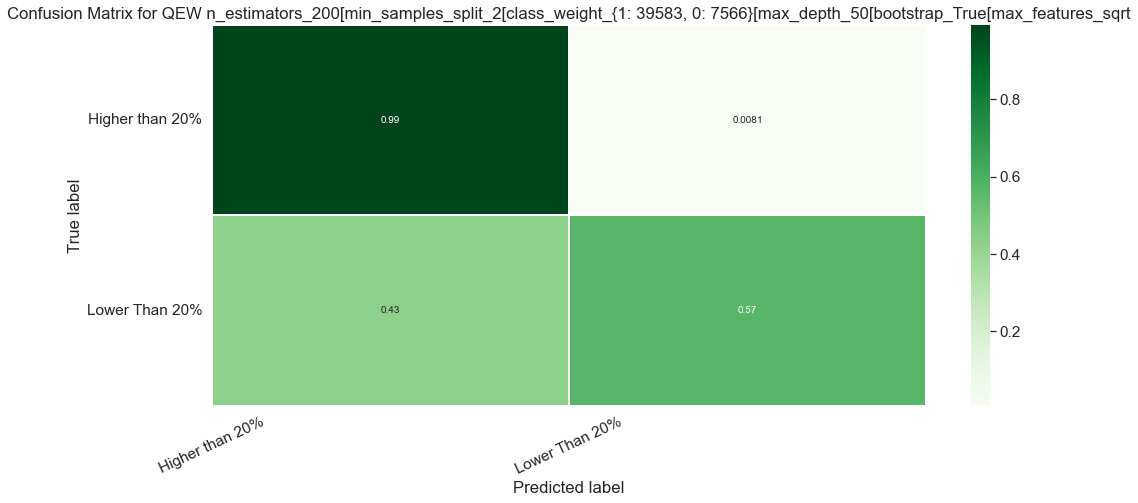

In [147]:
pars = {"n_estimators": 200,
"min_samples_split": 2,
"class_weight": {1: 39583, 0: 7566},
"max_depth": 50,
"bootstrap": True,
"max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: QEW n_estimators_100[min_samples_split_2[min_samples_leaf_2[max_depth_25[max_features_0.75
Training model QEW n_estimators_100[min_samples_split_2[min_samples_leaf_2[max_depth_25[max_features_0.75
Score 0.9354838709677419
Evaluating model QEW n_estimators_100[min_samples_split_2[min_samples_leaf_2[max_depth_25[max_features_0.75
upload complete (model)
0.9354838709677419
precision 0.9324932493249325
recall 0.6328649969456323
[[8766   75]
 [ 601 1036]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8841
           1       0.93      0.63      0.75      1637

    accuracy                           0.94     10478
   macro avg       0.93      0.81      0.86     10478
weighted avg       0.94      0.94      0.93     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


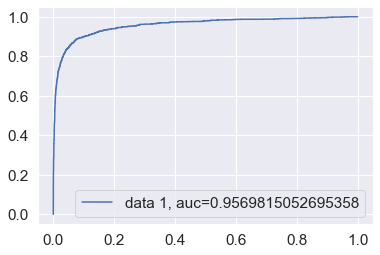

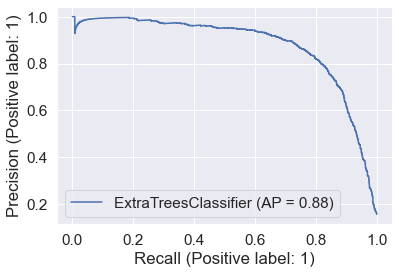

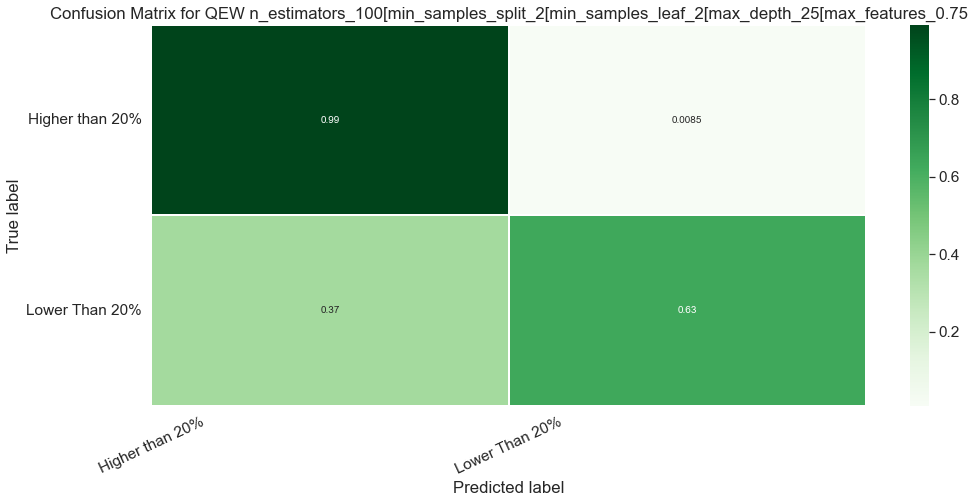

In [130]:
pars = {"n_estimators": 100,
"min_samples_split": 2,
"min_samples_leaf": 2,
"max_depth": 25,
"max_features": 0.75}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")

created new ExperimentRun: Donna n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
Training model Donna n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
Score 0.933765985875167
Evaluating model Donna n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
upload complete (model)
0.933765985875167
recision 0.9141965678627145
recall 0.6674259681093394
[[4306   55]
 [ 292  586]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4361
           1       0.91      0.67      0.77       878

    accuracy                           0.93      5239
   macro avg       0.93      0.83      0.87      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


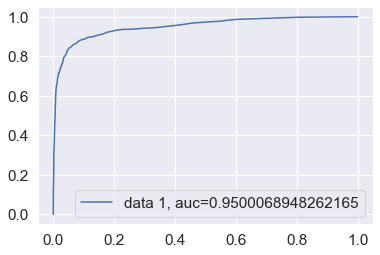

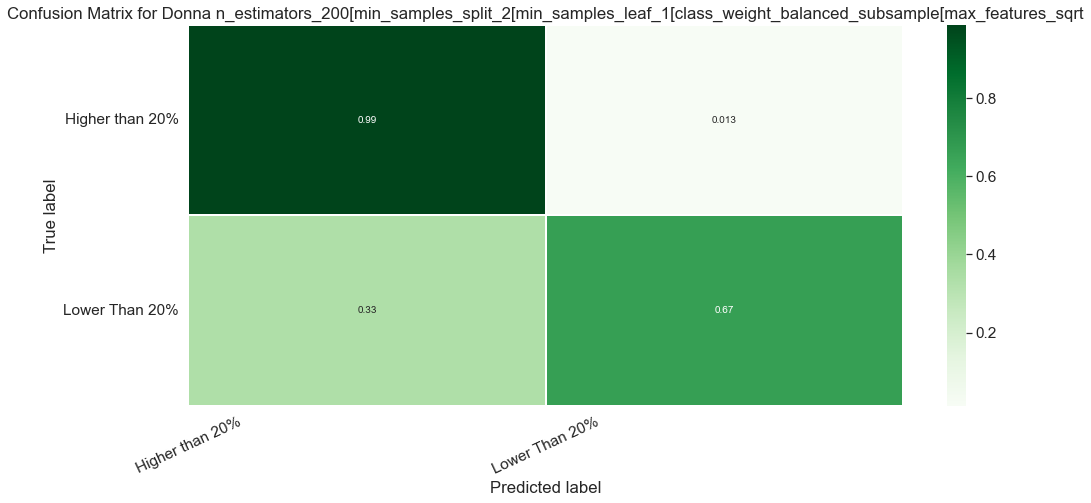

In [28]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Donna {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Training model Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.9347203664821531
Evaluating model Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
upload complete (model)
0.9347203664821531
recision 0.8785310734463276
recall 0.7084282460136674
[[4275   86]
 [ 256  622]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4361
           1       0.88      0.71      0.78       878

    accuracy                           0.93      5239
   macro avg       0.91      0.84      0.87      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


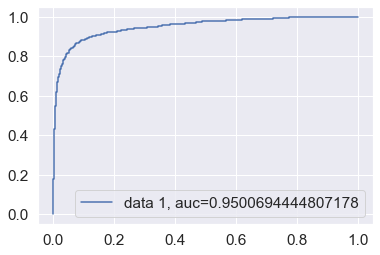

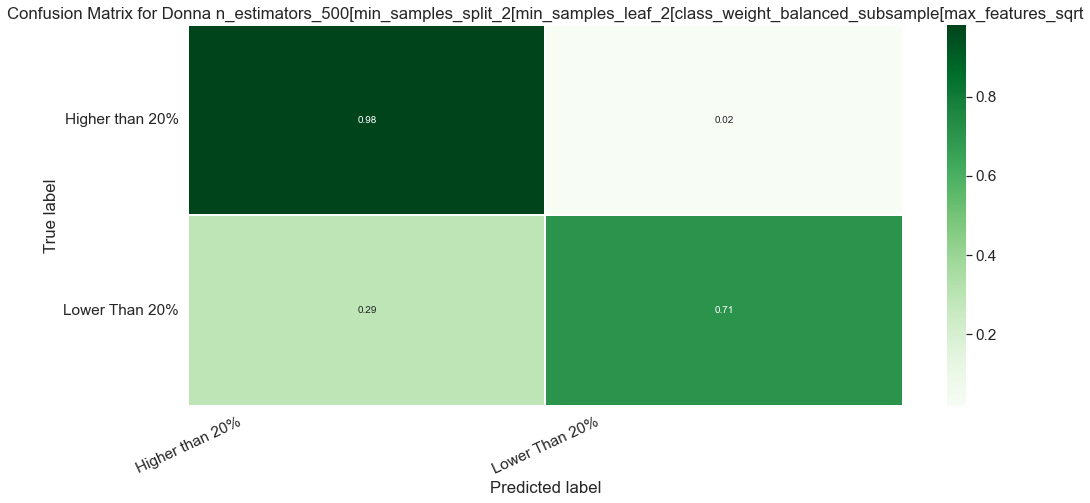

In [33]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Donna {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
Training model Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
Score 0.9352929948463448
Evaluating model Donna n_estimators_500[min_samples_split_2[min_samples_leaf_2[criterion_entropy[class_weight_balanced_subsample[max_features_sqrt
upload complete (model)
0.9352929948463448
recision 0.8801128349788434
recall 0.7107061503416856
[[4276   85]
 [ 254  624]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4361
           1       0.88      0.71      0.79       878

    accuracy                           0.94      5239
   macro avg       0.91      0.85      0.87      5239
weighted avg       0.93      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


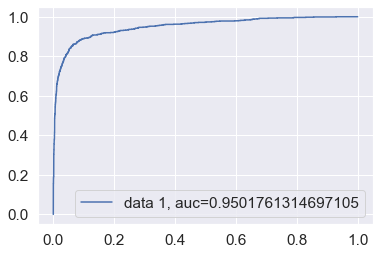

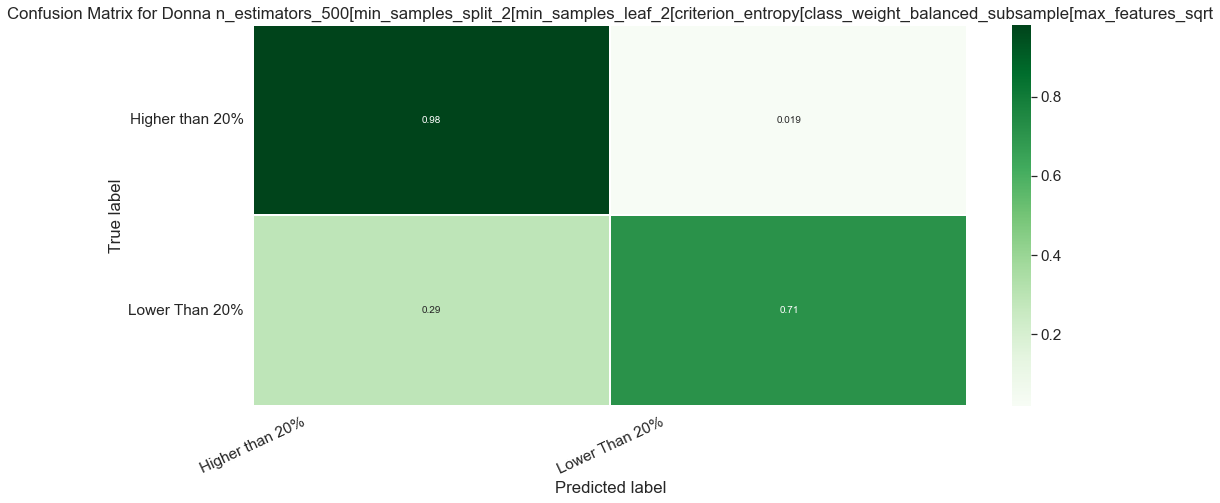

In [34]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"criterion": "entropy",
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Donna {'['.join(f'{k}_{v}' for k, v in pars.items())}")


In [79]:
y_train.value_counts()

label_20_up
0              39583
1               7566
dtype: int64

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import joblib
pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

y_train_1 = 7566
y_train_0 = 39583

hyperparameters_etG = {
"extratreesclassifier__n_estimators": (100, 200, 300, 500),
"extratreesclassifier__max_depth": (10, 20, 40, 50),
"extratreesclassifier__min_samples_split": (2, 3),
"extratreesclassifier__bootstrap": (True,),
"extratreesclassifier__min_samples_leaf": (1, 2, 3),
"extratreesclassifier__class_weight": ({1: 39583, 0: 7566})}
etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_etG,
                              n_jobs=4,
                              scoring='roc_auc',
                              verbose=6,
                              cv=5,
                              n_iter=100,
                              random_state=19)

In [103]:
et = ExtraTreesClassifier(random_state=19)

In [104]:
etG = et.fit(x_train, y_train)
joblib.dump(etG, "ET2_BASED.pkl")

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\3781991409.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  etG = et.fit(x_train, y_train)


['ET2_BASED.pkl']

In [105]:
etG_rsCV = etG_rscv.fit(x_train, y_train)
joblib.dump(etG_rsCV, "ET2_TUNED.pkl")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


['ET2_TUNED.pkl']

In [45]:
from model_factory import ModelFactory
_, y_class = ModelFactory.prepare_classification_label(df, -10)
y_class.value_counts()

2022-07-16 18:39:06,305 - root - INFO - Creating label column down_10_return with threshold of -10


KeyError: 'label_down_return'

In [106]:
etG_rsCV.best_params_

{'extratreesclassifier__n_estimators': 500,
 'extratreesclassifier__min_samples_split': 2,
 'extratreesclassifier__min_samples_leaf': 1,
 'extratreesclassifier__max_depth': 50,
 'extratreesclassifier__class_weight': 'balanced'}

In [107]:
etG_rsCV.best_score_

0.941400226978072

In [ ]:
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)

In [46]:

pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, f"RAGE {'['.join(f'{k}_{v}' for k, v in pars.items())}")

NameError: name 'd_x_train' is not defined

In [47]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
_, y_class = ModelFactory.prepare_classification_label(df, 50)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model("GIGA", pars))

2022-07-16 18:39:08,486 - root - INFO - Creating label column up_50_return with threshold of 50


KeyError: 'label_up_return'

In [48]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
label_col, y_class = ModelFactory.prepare_classification_label(df, 80)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model(f"GIGA {label_col}", pars))

2022-07-16 18:39:09,241 - root - INFO - Creating label column up_80_return with threshold of 80


KeyError: 'label_up_return'

In [ ]:
pars = {
'n_estimators': 150,
'min_samples_split': 2,
'min_samples_leaf': 2,
'max_samples': 0.8,
'max_features': 0.8,
'max_depth': 75,
'criterion': 'gini',
'class_weight': {0: 7566, 1: 39583},
'bootstrap': True
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"Donna {'['.join(f'{k}_{v}' for k, v in pars.items())}")

created new ExperimentRun: QEW n_estimators_200[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True
Training model QEW n_estimators_200[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True
Score 0.9276579499904561
Evaluating model QEW n_estimators_200[min_samples_split_2[min_samples_leaf_2[max_samples_0.8[max_features_0.8[class_weight_{1: 39583, 0: 7566}[max_depth_50[bootstrap_True
upload complete (model)
0.9276579499904561
precision 0.9287804878048781
recall 0.5815516188149054
[[8768   73]
 [ 685  952]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8841
           1       0.93      0.58      0.72      1637

    accuracy                           0.93     10478
   macro avg       0.93      0.79      0.84     10478
weighted avg       0.93      0.93      0.92     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


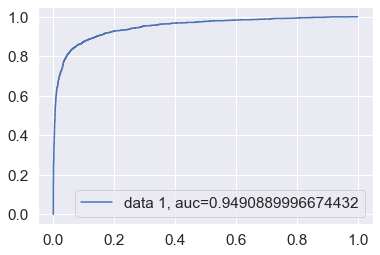

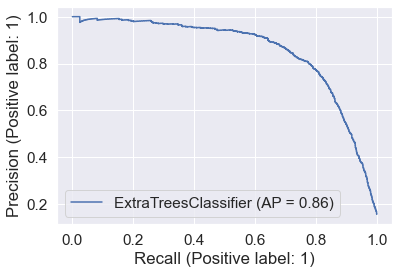

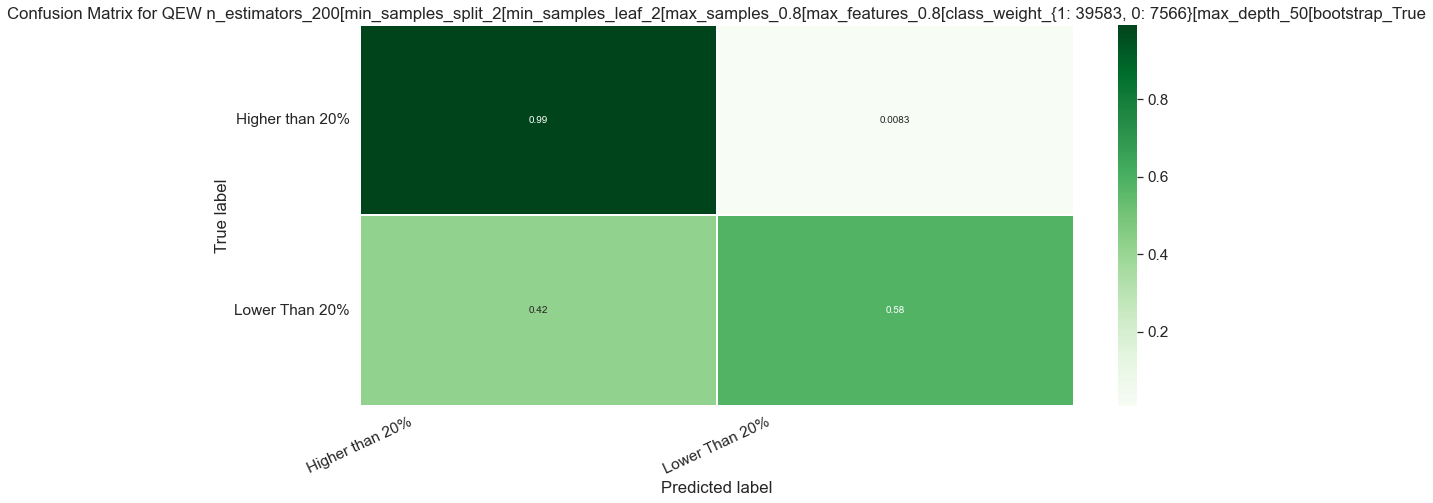

In [140]:

pars = {"n_estimators": 200,
'min_samples_split': 2,
'min_samples_leaf': 2,
'max_samples': 0.8,
'max_features': 0.8,
"class_weight": {1: 39583, 0: 7566},
"max_depth": 50,
"bootstrap": True}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"QEW {'['.join(f'{k}_{v}' for k, v in pars.items())}")


created new ExperimentRun: RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_40[bootstrap_True
Training model RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_40[bootstrap_True
Score 0.9225042947127314
Evaluating model RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_40[bootstrap_True
upload complete (model)
0.9225042947127314
precision 0.9411764705882353
recall 0.5375687232742822
[[8786   55]
 [ 757  880]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8841
           1       0.94      0.54      0.68      1637

    accuracy                           0.92     10478
   macro avg       0.93      0.77      0.82     10478
weighted avg       0.92      0.92      0.91     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


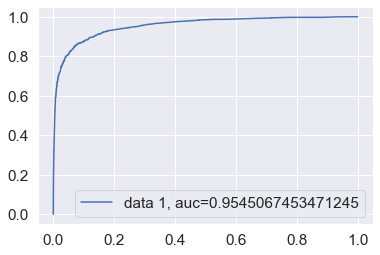

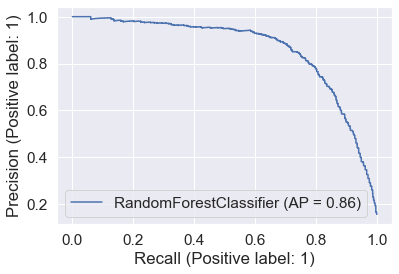

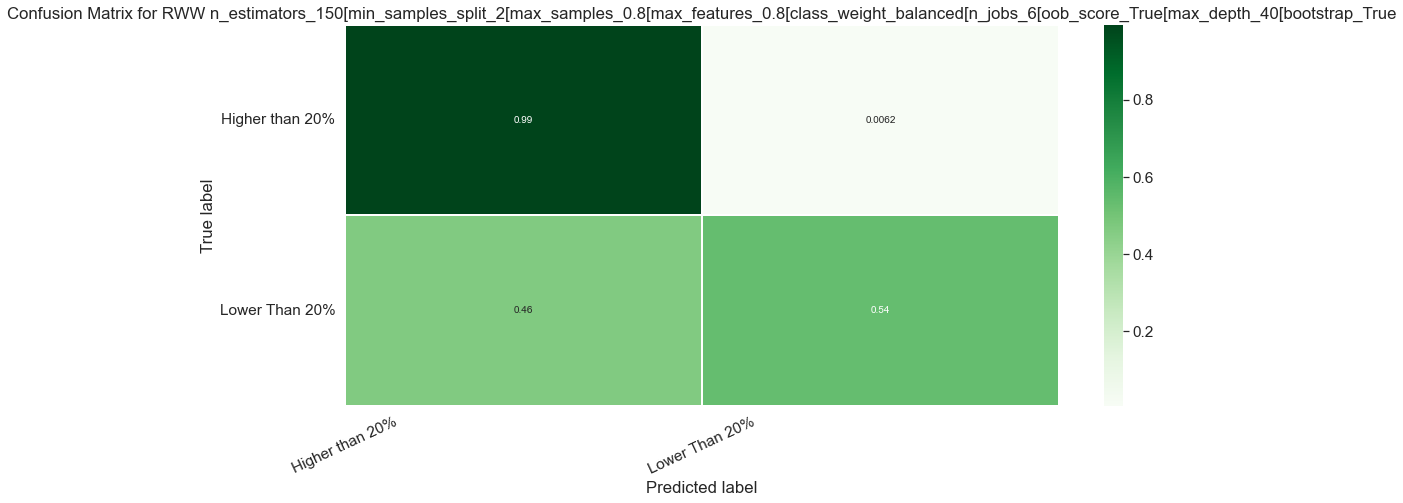

In [148]:
pars = {"n_estimators": 150,
'min_samples_split': 2,
'max_samples': 0.8,
'max_features': 0.8,
"class_weight": "balanced",
"n_jobs": 6,
"oob_score": True,
"max_depth": 40,
"bootstrap": True}
a1 = RandomForestClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"RWW {'['.join(f'{k}_{v}' for k, v in pars.items())}")



created new ExperimentRun: RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_50[bootstrap_True
Training model RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_50[bootstrap_True
Score 0.9224088566520329
Evaluating model RWW n_estimators_150[min_samples_split_2[max_samples_0.8[max_features_0.8[class_weight_balanced[n_jobs_6[oob_score_True[max_depth_50[bootstrap_True
upload complete (model)
0.9224088566520329
precision 0.9439655172413793
recall 0.535125229077581
[[8789   52]
 [ 761  876]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8841
           1       0.94      0.54      0.68      1637

    accuracy                           0.92     10478
   macro avg       0.93      0.76      0.82     10478
weighted avg       0.92      0.92      0.91     10478



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_15660\925143935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


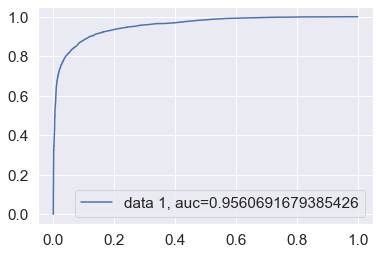

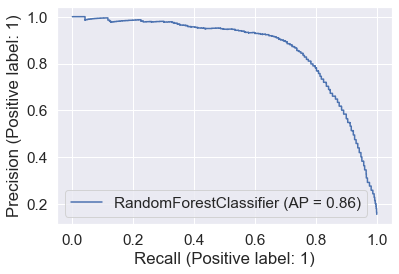

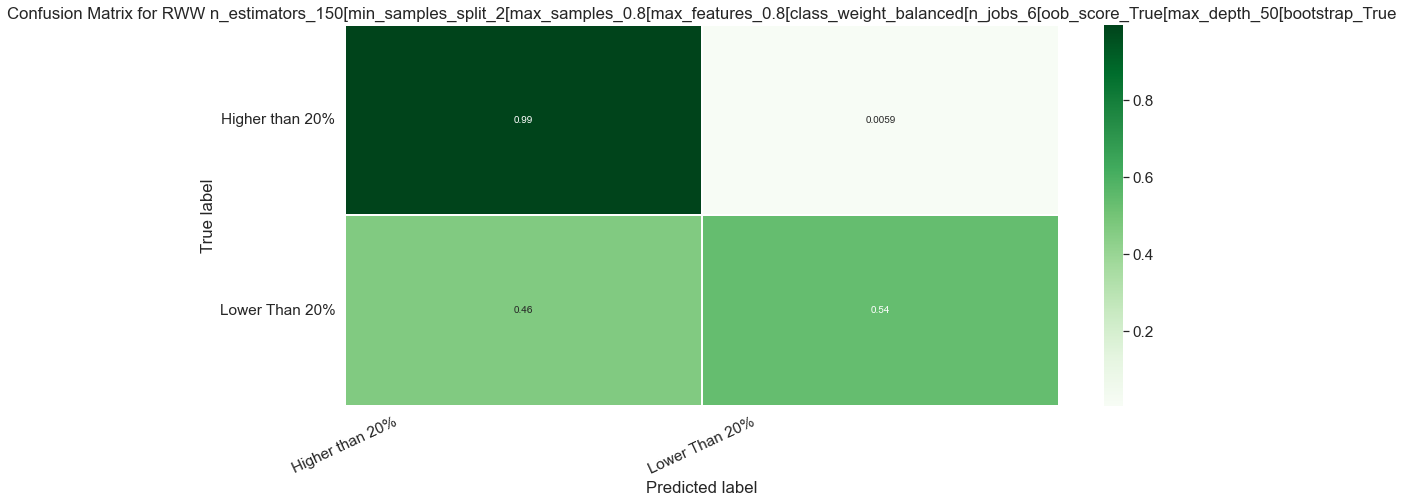

In [149]:
pars = {"n_estimators": 150,
'min_samples_split': 2,
'max_samples': 0.8,
'max_features': 0.8,
"class_weight": "balanced",
"n_jobs": 6,
"oob_score": True,
"max_depth": 50,
"bootstrap": True}
a1 = RandomForestClassifier(**pars)
train_eval_model(x_train, x_test, y_train, y_test, a1, f"RWW {'['.join(f'{k}_{v}' for k, v in pars.items())}")



In [1]:
feat_importances = pd.Series(a1.feature_importances_, index=x_train.columns)
feat_importances.nlargest(30).plot(kind='barh')
                                     

NameError: name 'pd' is not defined

In [2]:
feat_importances.nlargest(30)

NameError: name 'feat_importances' is not defined

In [165]:

y_test.iloc[0]

label_20_up    0
Name: 8169, dtype: int32

label_20_up    0
Name: 20874, dtype: int32

In [168]:
a1.predict_proba([x_test.iloc[0]])

C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\HUSTLE~1\AppData\Local\Temp\joblib_memmapping_folder_15660_41c558d81fc34b90bfcb1f6ec7be1776_cfda0575abb74e1ead07a87e9e36804a
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\joblib\_memmapping_reducer.py:607: UserWarning: Failed to delete temporary folder: C:\Users\HUSTLE~1\AppData\Local\Temp\joblib_memmapping_folder_15660_2d37d31350cc438b9d8f1490757b4042_c3ce99c5fbc947d7a0af4efab6a8a500
  warnings.warn("Failed to delete temporary folder: {}"


array([[0.57333333, 0.42666667]])